In [1]:
import matplotlib.pyplot as plt
import mpmath as mp
mp.mp.dps = 30 #higher precision
import pandas as pd
from PyMatching import *
import scipy

In [2]:
def load_data(size, p, intervals, iterations, overlap, walkers, alpha, beta, exchange, boundary):
    """
    Load the pickled DataFrame based on input parameters.
    """
    filename = (
        f"../results_curves/{boundary}/X_{size}_Y_{size}/prob_{p:.6f}/"
        f"free_energies_intervals_{intervals}_iterations_{iterations}_"
        f"overlap_{overlap:.6f}_walkers_{walkers}_alpha_{alpha:.6f}_beta_{beta:.10f}_"
        f"exchange_offset_{exchange}.pickle"
    )
    return pd.read_pickle(filename)


In [3]:
def calculate_curve(df_grouped, energy_type):
    """
    Calculate the success curve and its components (lower and upper bounds)
    for the specified energy type ('nish_temp' or 'low_temp').
    """
    curve = mp.mpf(1)

    for _, df_run in df_grouped:
        free_energy_I = df_run.loc[df_run['error'] == 'I', f'free_energy_{energy_type}'].values[0]
        other_errors = df_run.loc[df_run['error'] != 'I', f'free_energy_{energy_type}']

        # Update the curve based on the condition
        curve -= mp.mpf(int((free_energy_I < other_errors).any())) / mp.mpf(len(df_grouped))

    return curve

In [4]:
def calculate_bounds(curve, successes, failures):
    """
    Calculate the lower and upper bounds for the curve using a beta distribution.
    """
    lower_bound = curve - scipy.stats.beta.ppf(0.025, 0.5 + successes, 0.5 + failures)
    upper_bound = scipy.stats.beta.ppf(0.975, 0.5 + successes, 0.5 + failures) - curve
    return lower_bound, upper_bound

In [5]:
def process_data(df, size, p, low_temp_dict, nish_temp_dict):
    """
    Process the DataFrame to compute success curves and their bounds
    for both nish and low temperature cases.
    """
    # Group by 'histogram_seed' to avoid explicit loops
    grouped_df = df.groupby('histogram_seed')

    # Calculate curves for both energy types
    nish_curve = calculate_curve(grouped_df, 'nish_temp')
    low_temp_curve = calculate_curve(grouped_df, 'low_temp')

    # Calculate the number of successes and failures
    number_success_nish = round(len(grouped_df) * nish_curve)
    number_success_low_temp = round(len(grouped_df) * low_temp_curve)

    number_failure_nish = len(grouped_df) - number_success_nish
    number_failure_low_temp = len(grouped_df) - number_success_low_temp

    # Calculate bounds for both curves
    lower_bound_nish, upper_bound_nish = calculate_bounds(nish_curve, number_success_nish, number_failure_nish)
    lower_bound_low_temp, upper_bound_low_temp = calculate_bounds(low_temp_curve, number_success_low_temp, number_failure_low_temp)

    if size not in low_temp_dict:
        low_temp_dict[size] = {}
    if size not in nish_temp_dict:
        nish_temp_dict[size] = {}

    # Store results in the dictionaries
    low_temp_dict[size][p] = [low_temp_curve, lower_bound_low_temp, upper_bound_low_temp]
    nish_temp_dict[size][p] = [nish_curve, lower_bound_nish, upper_bound_nish]

In [6]:
boundary_type = "periodic"
batch_results = []
probabilities = [0.1, 0.11, 0.12, 0.13]
sizes = [4, 6, 8, 10]
intervals = 10
iterations = 1000
overlap = 0.25
walkers = 8
alpha = 0.8
beta = 1e-8
exchange = 20

In [7]:
nish_dict = {}
low_dict = {}

for size in sizes:

    if size == 8:
        intervals = 20
    if size == 10:
        intervals = 40

    for p in probabilities:
        df = load_data(size, p, intervals, iterations, overlap, walkers, alpha, beta, exchange, boundary_type)
        process_data(df, size, p, low_dict, nish_dict)

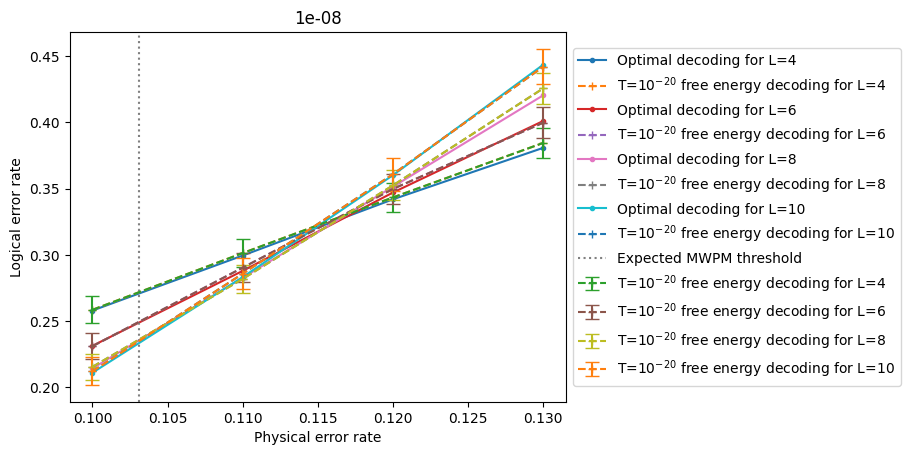

In [8]:
for i, size in enumerate(sizes):
    plt.plot(probabilities, [1-nish_dict[size][j][0] for j in probabilities],".-",label=r"Optimal decoding for L=%d"%size)
    plt.plot(probabilities, [1-low_dict[size][j][0] for j in probabilities],"+--",label=r"T=$10^{-20}$ free energy decoding for L=%d"%size)
    plt.errorbar(probabilities, [1 - low_dict[size][j][0] for j in probabilities],
                 yerr=[[ low_dict[size][j][2]  for j in probabilities], [low_dict[size][j][1]for j in probabilities]],
                 fmt='+--', label=r"T=$10^{-20}$ free energy decoding for L=%d" % size, capsize=5)


plt.axvline(x=0.1031,color="gray",label="Expected MWPM threshold",linestyle="dotted")

plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")

#plt.xscale('log')
#plt.yscale('log')
#plt.ylim(bottom=1e-4, top=None)
plt.title(beta)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Minimum energy based decoders

In [60]:
df_copy = df.copy()

In [61]:
df_copy['E_min'] = df_copy['E'].apply(min)

In [62]:
df_copy['group_min_E_min'] = (
    df_copy.groupby(['prob', 'X', 'Y', 'histogram_seed'])['E_min']
    .transform('min')
)

df_copy['is_min_E'] = df_copy['E_min'] == df_copy['group_min_E_min']
df_copy['is_min_E'] = df_copy['is_min_E'].astype(int)


In [63]:
def select_random_error_class(group):
    min_errors = group[group['is_min_E'] == 1]

    if min_errors.empty:
        raise ValueError("No errors with is_min_E == 1 found in the group.")
    selected_error = np.random.choice(min_errors['error'])
    return selected_error

In [64]:
df_selected_errors = (
    df_copy.groupby(['prob', 'X', 'Y', 'histogram_seed'])
    .apply(select_random_error_class)
    .reset_index(name='selected_error', level=[0, 1, 2, 3])
)

/tmp/ipykernel_54195/766864152.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_copy.groupby(['prob', 'X', 'Y', 'histogram_seed'])


In [65]:
error_free_energy_df = df_copy[['prob', 'X', 'Y', 'histogram_seed', 'error', 'free_energy_nish_temp']]

df_merged = df_selected_errors.merge(
    error_free_energy_df,
    left_on=['prob', 'X', 'Y', 'histogram_seed', 'selected_error'],
    right_on=['prob', 'X', 'Y', 'histogram_seed', 'error'],
    how='left',
    suffixes=('', '_selected')
)

df_merged.rename(columns={'free_energy_nish_temp_selected': 'free_energy_nish_temp_selected'}, inplace=True)


In [66]:
display(df_merged)

,prob,X,Y,histogram_seed,selected_error,error,free_energy_nish_temp
0,0.13,10,10,1,I,I,151.70893737152832348349651892
1,0.13,10,10,10,I,I,162.261400694085649550134164675
2,0.13,10,10,100,I,I,157.405594717616865484376307959
3,0.13,10,10,1000,I,I,155.609362253491173261115984682
4,0.13,10,10,10002,I,I,157.966232840741293596756580666
...,...,...,...,...,...,...,...
5362,0.13,10,10,9994,Z,Z,154.878326814976951460152609172
5363,0.13,10,10,9996,I,I,155.764285864859825241649002988
5364,0.13,10,10,9997,Y,Y,151.315589886483778076405850146
5365,0.13,10,10,9998,Z,Z,153.232416885856760471994979791


In [71]:
df_copy = df_copy.merge(df_merged, on=['prob', 'X', 'Y', 'histogram_seed'], how='left', suffixes=('', '_selected'))


,prob,X,Y,error,histogram_seed,run_seed,E,log_g,rescaled_log_g,free_energy_low_temp,free_energy_nish_temp,free_energy_high_temp,E_min,group_min_E_min,is_min_E,selected_error,free_energy_nish_temp_selected,selected_error_selected,free_energy_nish_temp_selected
0,0.13,10,10,I,1,230,"[-152, -148, -144, -140, -136, -132, -128, -12...","[4.951922451803753, 9.587390545482108, 13.5159...","[4.95192245180374357510614920196, 9.5873905454...",15200000000000000000004.9519225,151.70893737152832348349651892,69.3147180559945309417266855691,-152,-152,1,I,151.70893737152832348349651892,I,151.70893737152832348349651892
1,0.13,10,10,X,1,231,"[-148, -144, -140, -136, -132, -128, -124, -12...","[8.972169943269968, 13.3614681699543, 16.98378...","[8.97216994326997157513143122731, 13.361468169...",14800000000000000000008.9721699,151.382340513395848451762861624,69.3147180559945309417224677069,-148,-152,0,I,151.70893737152832348349651892,I,151.70893737152832348349651892
2,0.13,10,10,Y,1,232,"[-152, -148, -144, -140, -136, -132, -128, -12...","[5.197223305394658, 10.265939514776477, 14.097...","[5.19722330539463609778526144587, 10.265939514...",15200000000000000000005.1972233,152.179419123854131840822620651,69.3147180559945309417239429735,-152,-152,1,I,151.70893737152832348349651892,I,151.70893737152832348349651892
3,0.13,10,10,Z,1,233,"[-148, -144, -140, -136, -132, -128, -124, -12...","[8.901803256899676, 13.204198468432388, 16.905...","[8.90180325689966776622798771234, 13.204198468...",14800000000000000000008.9018033,151.307575694986563736185612399,69.3147180559945309417215028506,-148,-152,0,I,151.70893737152832348349651892,I,151.70893737152832348349651892
4,0.13,10,10,I,10,230,"[-164, -160, -156, -152, -148, -144, -140, -13...","[5.569277908730633, 9.05536478206826, 12.09938...","[5.56927790873062661697964762663, 9.0553647820...",16400000000000000000005.5692779,162.261400694085649550134164675,69.3147180559945309417243276849,-164,-164,1,I,162.261400694085649550134164675,I,162.261400694085649550134164675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21463,0.13,10,10,Z,9998,28,"[-156, -152, -148, -144, -140, -136, -132, -12...","[2.934704494779339, 7.255708602373829, 11.1687...","[2.93470449477932564885113282041, 7.2557086023...",15600000000000000000002.9347045,153.232416885856760471994979791,69.3147180559945309417251678834,-156,-156,1,Z,153.232416885856760471994979791,Z,153.232416885856760471994979791
21464,0.13,10,10,I,9999,25,"[-154, -150, -146, -142, -138, -134, -130, -12...","[4.883368207152515, 9.5497801341224, 13.319183...","[4.88336820715249804088882335178, 9.5497801341...",15400000000000000000004.8833682,153.364464173693205946672547122,69.3147180559945309417226199386,-154,-154,1,Z,153.193943221143569619816714223,Z,153.193943221143569619816714223
21465,0.13,10,10,X,9999,26,"[-150, -146, -142, -138, -134, -130, -126, -12...","[7.717639171953444, 12.147871633495335, 15.804...","[7.71763917195342944392379081633, 12.147871633...",15000000000000000000007.7176392,152.10110222356316370778366917,69.3147180559945309417221406503,-150,-154,0,Z,153.193943221143569619816714223,Z,153.193943221143569619816714223
21466,0.13,10,10,Y,9999,27,"[-150, -146, -142, -138, -134, -130, -126, -12...","[7.097179822878672, 12.047173278661205, 15.880...","[7.09717982287865938674820789085, 12.047173278...",15000000000000000000007.0971798,152.084580584897941893803676589,69.3147180559945309417274570848,-150,-154,0,Z,153.193943221143569619816714223,Z,153.193943221143569619816714223


In [ ]:
df_copy.drop('error_selected', axis=1)

In [ ]:
df_copy['free_energy_nish_temp_deviation_from_selected_error_class'] = df_copy['free_energy_nish_temp'] - df_copy['free_energy_nish_temp']